In [250]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score

#1. Reading, understanding and visualising the data<br>
#2. Prepare the data for modelling<br>
#3. Train the model - Learn coeff and intercept<br>
#4. Residual Analysis<br>
#5. Make prediction on the test set<br>

In [251]:
#read the data
bike_rental = pd.read_csv("day.csv")
bike_rental.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [252]:
#Check the number of rows
bike_rental.shape

(730, 16)

In [253]:
#Check the datatype of all the columns in the dataframe
bike_rental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [254]:
#None of the columns are null, almost all of them have float and int datatypes
#dteday has object datatype and the info it has is contained within yr, month, weekday and workingday column. 
#We will go ahead and dteday col
bike_rental = bike_rental.drop("dteday", axis =1)

In [255]:
# We will also remove the instant column as it is just an index and does not serve any purpose for linear regression
bike_rental = bike_rental.drop("instant", axis =1)

In [256]:
#Check the number of null values in the columns
bike_rental.isnull().sum()

season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

## Univariate Analysis

C:\Users\chetna.priyadarshin\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


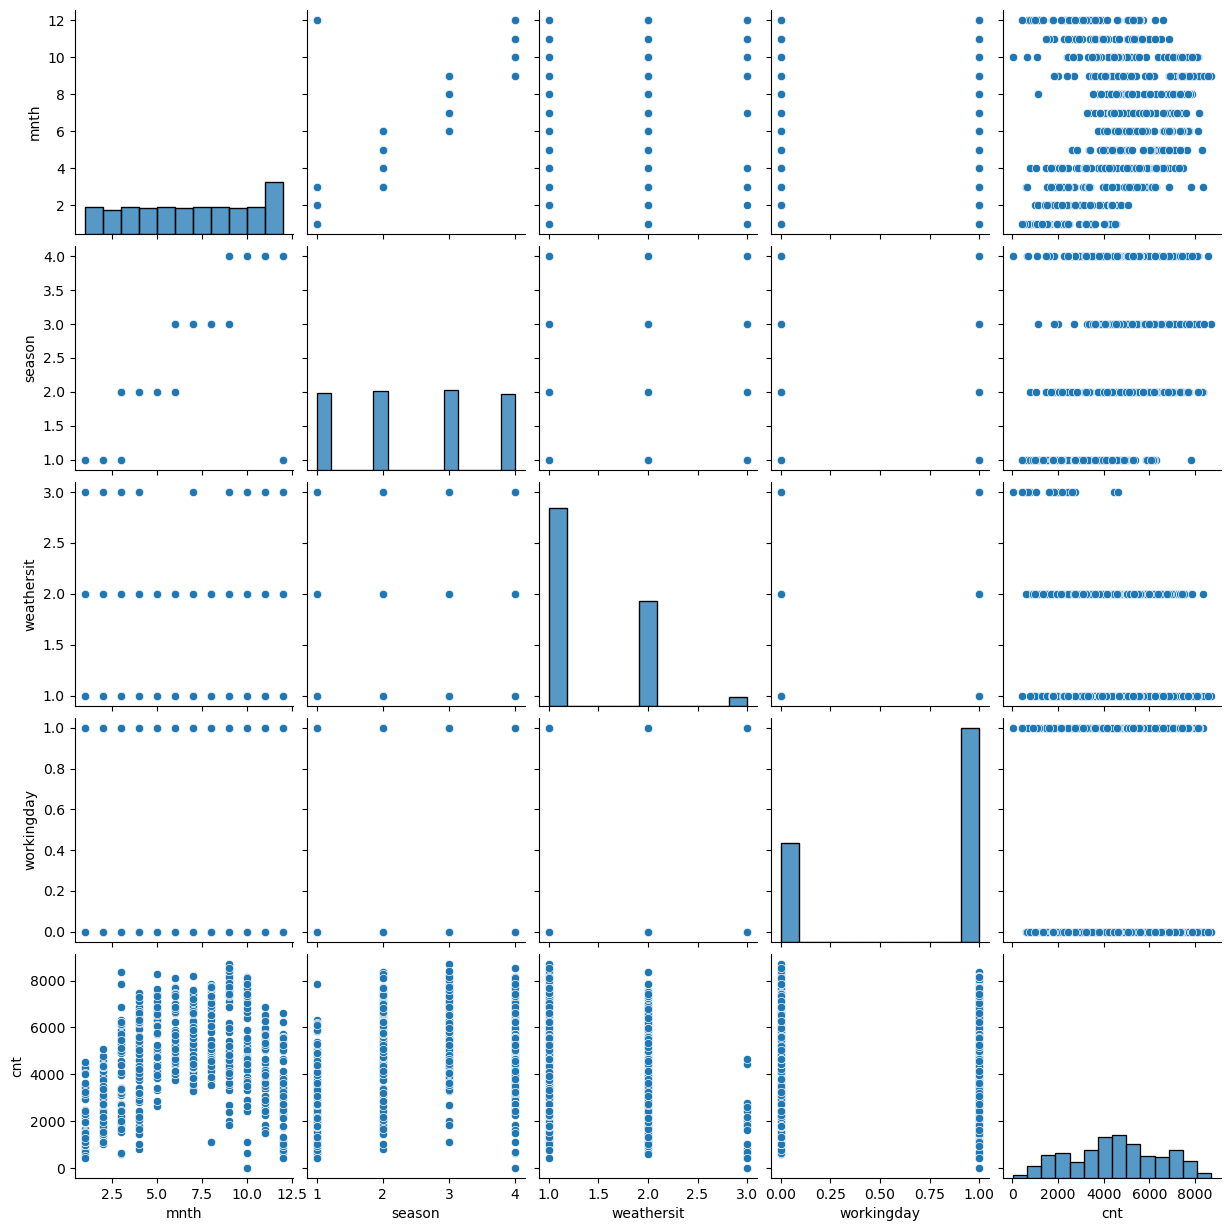

In [257]:
#visualising the categorical variables
bike_rental_sub = bike_rental[["mnth", "season", "weathersit", "workingday", "cnt"]]
sns.pairplot(bike_rental_sub)
plt.show()

C:\Users\chetna.priyadarshin\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


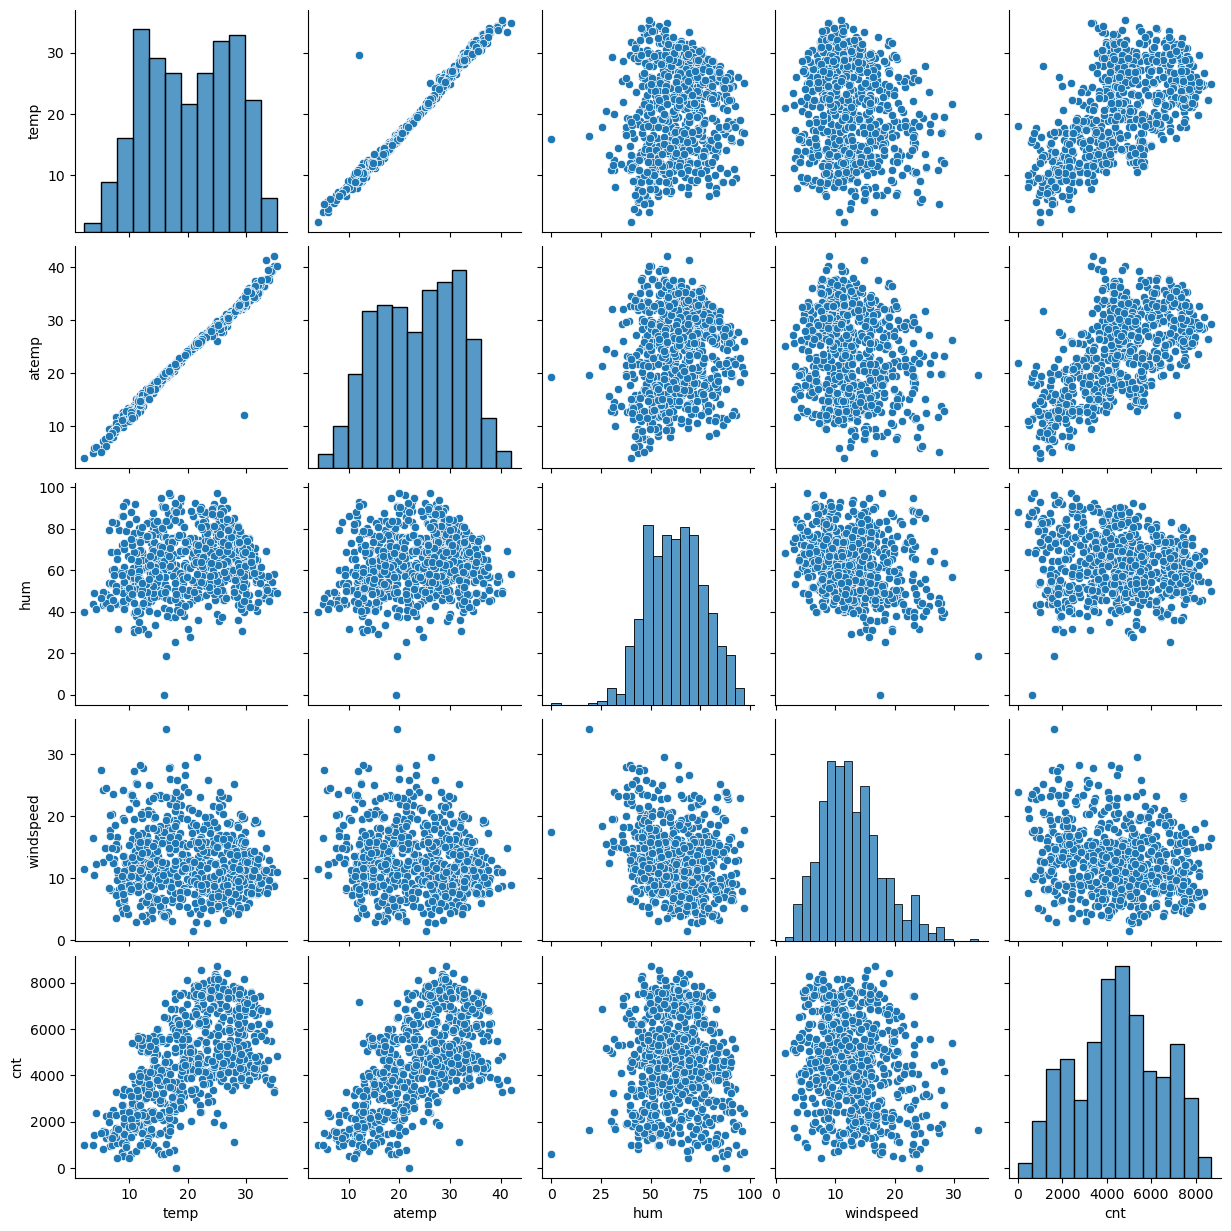

In [258]:
#Visualising the numeric variables
bike_rental_sub = bike_rental[["temp", "atemp", "hum", "windspeed", "cnt"]]
sns.pairplot(bike_rental_sub)
plt.show()

#####  Analysis:
1. Temp mostly spread 15 -25
2. Humidity between 50 -75
3. atemp between 15 and 35
4. Windspeed between 15 and 20

###### Bivariate Relationship

1. atemp and temp have linear relationship which might suggest collinearity
2. There does not seem to be linear relationship between other pairs of data

## Bivariate Analysis against target variable cnt

<Axes: xlabel='mnth', ylabel='cnt'>

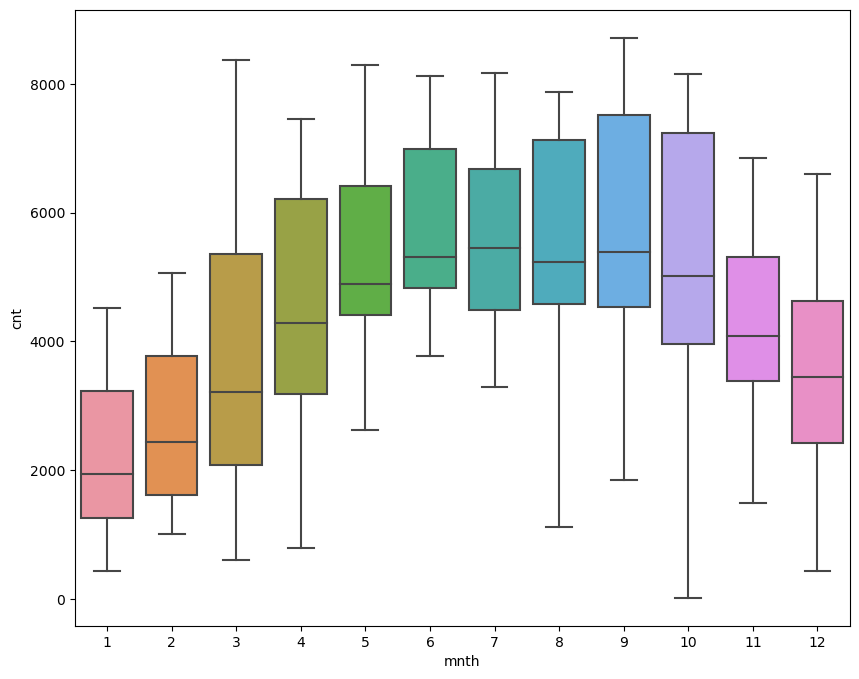

In [16]:
#visualising the categorical variables
plt.figure(figsize=(10,8))
sns.boxplot(x='mnth', y='cnt', data = bike_rental)

#### We can see that bike rentals are high in summer months

<Axes: xlabel='weekday', ylabel='cnt'>

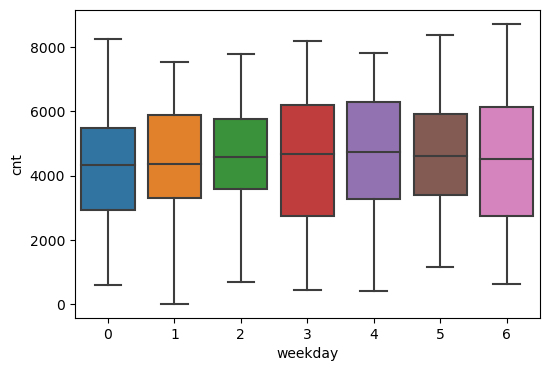

In [17]:
#visualising the categorical variables
plt.figure(figsize=(6,4))
sns.boxplot(x='weekday', y='cnt', data = bike_rental)

#### Bike rentals does not seem to vary a lot by weekday, it looks to be a little higher on Wed and Thu

<Axes: xlabel='season', ylabel='cnt'>

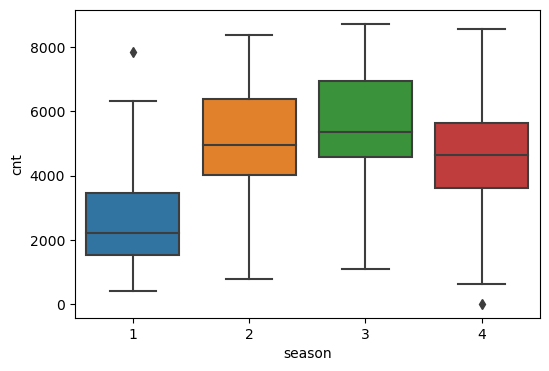

In [18]:
plt.figure(figsize=(6,4))
sns.boxplot(x='season', y='cnt', data = bike_rental)

##### Bike rentals are higher during Summer and Fall

<Axes: xlabel='weathersit', ylabel='cnt'>

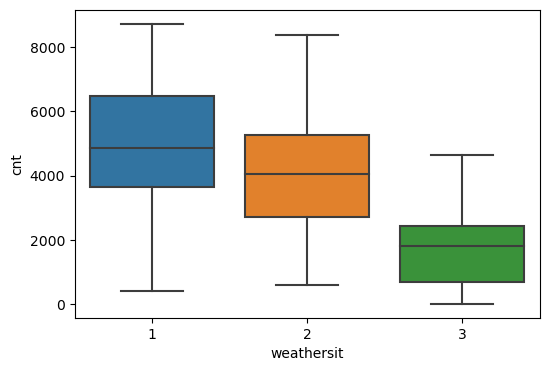

In [19]:
plt.figure(figsize=(6,4))
sns.boxplot(x='weathersit', y='cnt', data = bike_rental)

#### People prefer to rent bikes on cloudy days. LightSnow has least number of bike rentals

In [20]:
#Handle categorical variables 

# As first step convert Number to String

#1. weekday - 1,2,3,4,5,6,7 - Mon, Tue, Wed, Thurs, Fri, Sat, Sun
#2. mnth - Convert Number to Strings - Jan, Feb, Mar, Apr, May, Jun, July, Aug, Sept, Oct, Nov, Dec
#3. season - 1:spring, 2:summer, 3:fall, 4:winter
#4. weathersit - 1. clear 2. cloudy 3. lightSnow 4. heavyRain

In [21]:
bike_rental.weekday = bike_rental.weekday.map({1: "Mon", 2: "Tue", 3: "Wed", 4: "Thu", 5: "Fri", 6: "Sat", 0: "Sun"})
bike_rental.mnth = bike_rental.mnth.map({1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 7: "July", 8: "Aug", 9: "Sept", 10: "Oct", 11: "Nov", 12: "Dec"})
bike_rental.season = bike_rental.season.map({1: "spring", 2:"summer", 3: "fall", 4: "winter"})
bike_rental.weathersit = bike_rental.weathersit.map({1: "clear", 2: "cloudy", 3: "lightsnow", 4: "heavyrain"})
bike_rental.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,spring,0,Jan,0,Sat,0,cloudy,14.110847,18.18125,80.5833,10.749882,331,654,985
1,spring,0,Jan,0,Sun,0,cloudy,14.902598,17.68695,69.6087,16.652113,131,670,801
2,spring,0,Jan,0,Mon,1,clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,spring,0,Jan,0,Tue,1,clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,spring,0,Jan,0,Wed,1,clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [22]:
#Now for each of the categorical variables we need to create dummy vars that covers the info.
#If there are 4 values there will be three dummy vars

#We will start with season
status = pd.get_dummies(bike_rental["season"],drop_first = True, dtype = int)
status.head()

,spring,summer,winter
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [23]:
bike_rental = pd.concat([bike_rental, status], axis = 1)

In [24]:
bike_rental.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,spring,summer,winter
0,spring,0,Jan,0,Sat,0,cloudy,14.110847,18.18125,80.5833,10.749882,331,654,985,1,0,0
1,spring,0,Jan,0,Sun,0,cloudy,14.902598,17.68695,69.6087,16.652113,131,670,801,1,0,0
2,spring,0,Jan,0,Mon,1,clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349,1,0,0
3,spring,0,Jan,0,Tue,1,clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562,1,0,0
4,spring,0,Jan,0,Wed,1,clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600,1,0,0


In [25]:
#We can now drop season
bike_rental = bike_rental.drop("season", axis = 1)
bike_rental.head()

,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,spring,summer,winter
0,0,Jan,0,Sat,0,cloudy,14.110847,18.18125,80.5833,10.749882,331,654,985,1,0,0
1,0,Jan,0,Sun,0,cloudy,14.902598,17.68695,69.6087,16.652113,131,670,801,1,0,0
2,0,Jan,0,Mon,1,clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349,1,0,0
3,0,Jan,0,Tue,1,clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562,1,0,0
4,0,Jan,0,Wed,1,clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600,1,0,0


In [26]:
#Dummy vars for weekday
status = pd.get_dummies(bike_rental["weekday"],drop_first = True, dtype = int)
bike_rental = pd.concat([bike_rental, status], axis = 1)
bike_rental = bike_rental.drop("weekday", axis = 1)
bike_rental.head()

,yr,mnth,holiday,workingday,weathersit,temp,atemp,hum,windspeed,casual,...,cnt,spring,summer,winter,Mon,Sat,Sun,Thu,Tue,Wed
0,0,Jan,0,0,cloudy,14.110847,18.18125,80.5833,10.749882,331,...,985,1,0,0,0,1,0,0,0,0
1,0,Jan,0,0,cloudy,14.902598,17.68695,69.6087,16.652113,131,...,801,1,0,0,0,0,1,0,0,0
2,0,Jan,0,1,clear,8.050924,9.47025,43.7273,16.636703,120,...,1349,1,0,0,1,0,0,0,0,0
3,0,Jan,0,1,clear,8.200000,10.60610,59.0435,10.739832,108,...,1562,1,0,0,0,0,0,0,1,0
4,0,Jan,0,1,clear,9.305237,11.46350,43.6957,12.522300,82,...,1600,1,0,0,0,0,0,0,0,1


In [27]:
#Dummy vars for mnth
status = pd.get_dummies(bike_rental["mnth"],drop_first = True, dtype = int)
bike_rental = pd.concat([bike_rental, status], axis = 1)
bike_rental = bike_rental.drop("mnth", axis = 1)
bike_rental.head()

,yr,holiday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,...,Dec,Feb,Jan,July,Jun,Mar,May,Nov,Oct,Sept
0,0,0,0,cloudy,14.110847,18.18125,80.5833,10.749882,331,654,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,cloudy,14.902598,17.68695,69.6087,16.652113,131,670,...,0,0,1,0,0,0,0,0,0,0
2,0,0,1,clear,8.050924,9.47025,43.7273,16.636703,120,1229,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1,clear,8.200000,10.60610,59.0435,10.739832,108,1454,...,0,0,1,0,0,0,0,0,0,0
4,0,0,1,clear,9.305237,11.46350,43.6957,12.522300,82,1518,...,0,0,1,0,0,0,0,0,0,0


In [28]:
#Dummy vars for weathersit
status = pd.get_dummies(bike_rental["weathersit"],drop_first = True, dtype = int)
bike_rental = pd.concat([bike_rental, status], axis = 1)
bike_rental = bike_rental.drop("weathersit", axis = 1)
bike_rental.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,...,Jan,July,Jun,Mar,May,Nov,Oct,Sept,cloudy,lightsnow
0,0,0,0,14.110847,18.18125,80.5833,10.749882,331,654,985,...,1,0,0,0,0,0,0,0,1,0
1,0,0,0,14.902598,17.68695,69.6087,16.652113,131,670,801,...,1,0,0,0,0,0,0,0,1,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349,...,1,0,0,0,0,0,0,0,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,...,1,0,0,0,0,0,0,0,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600,...,1,0,0,0,0,0,0,0,0,0


In [29]:
bike_rental.shape

(730, 32)

In [32]:
# Remove casual and registered columns from dataframe, cnt is our predictor column and it is addition of casual and registered.
# We cannot use it for training

bike_rental_casual_registered = bike_rental[["casual", "registered"]]
bike_rental_casual_registered.head

<bound method NDFrame.head of      casual  registered
0       331         654
1       131         670
2       120        1229
3       108        1454
4        82        1518
..      ...         ...
725     247        1867
726     644        2451
727     159        1182
728     364        1432
729     439        2290

[730 rows x 2 columns]>

In [45]:
bike_rental = bike_rental.drop("casual", axis=1)
bike_rental = bike_rental.drop("registered", axis = 1)
bike_rental.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,Jan,July,Jun,Mar,May,Nov,Oct,Sept,cloudy,lightsnow
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,...,1,0,0,0,0,0,0,0,1,0
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,...,1,0,0,0,0,0,0,0,1,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,...,1,0,0,0,0,0,0,0,0,0


#### We took away 6 columns and added 18 columns
#### Let's now split the data in train and test

In [195]:
df_train, df_test = train_test_split(bike_rental, train_size = 0.7, random_state = 100)
df_train.shape

(510, 30)

In [196]:
bike_rental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   yr          730 non-null    int64  
 1   holiday     730 non-null    int64  
 2   workingday  730 non-null    int64  
 3   temp        730 non-null    float64
 4   atemp       730 non-null    float64
 5   hum         730 non-null    float64
 6   windspeed   730 non-null    float64
 7   cnt         730 non-null    int64  
 8   spring      730 non-null    int32  
 9   summer      730 non-null    int32  
 10  winter      730 non-null    int32  
 11  Mon         730 non-null    int32  
 12  Sat         730 non-null    int32  
 13  Sun         730 non-null    int32  
 14  Thu         730 non-null    int32  
 15  Tue         730 non-null    int32  
 16  Wed         730 non-null    int32  
 17  Aug         730 non-null    int32  
 18  Dec         730 non-null    int32  
 19  Feb         730 non-null    i

#### Scale the numerical columns using the MinMax scaler

In [197]:
scaler = MinMaxScaler()
num_vars = ['temp', 'atemp', 'hum', 'windspeed']
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,Jan,July,Jun,Mar,May,Nov,Oct,Sept,cloudy,lightsnow
576,1,0,1,0.815169,0.766351,0.725633,0.264686,7216,0,0,...,0,1,0,0,0,0,0,0,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,4066,1,0,...,0,0,0,1,0,0,0,0,1,0
728,1,0,0,0.245101,0.200348,0.498067,0.663106,1796,1,0,...,0,0,0,0,0,0,0,0,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,4220,0,1,...,0,0,0,0,0,0,0,0,1,0
111,0,0,1,0.345824,0.318819,0.751824,0.380981,1683,0,1,...,0,0,0,0,0,0,0,0,1,0


#### Training the model

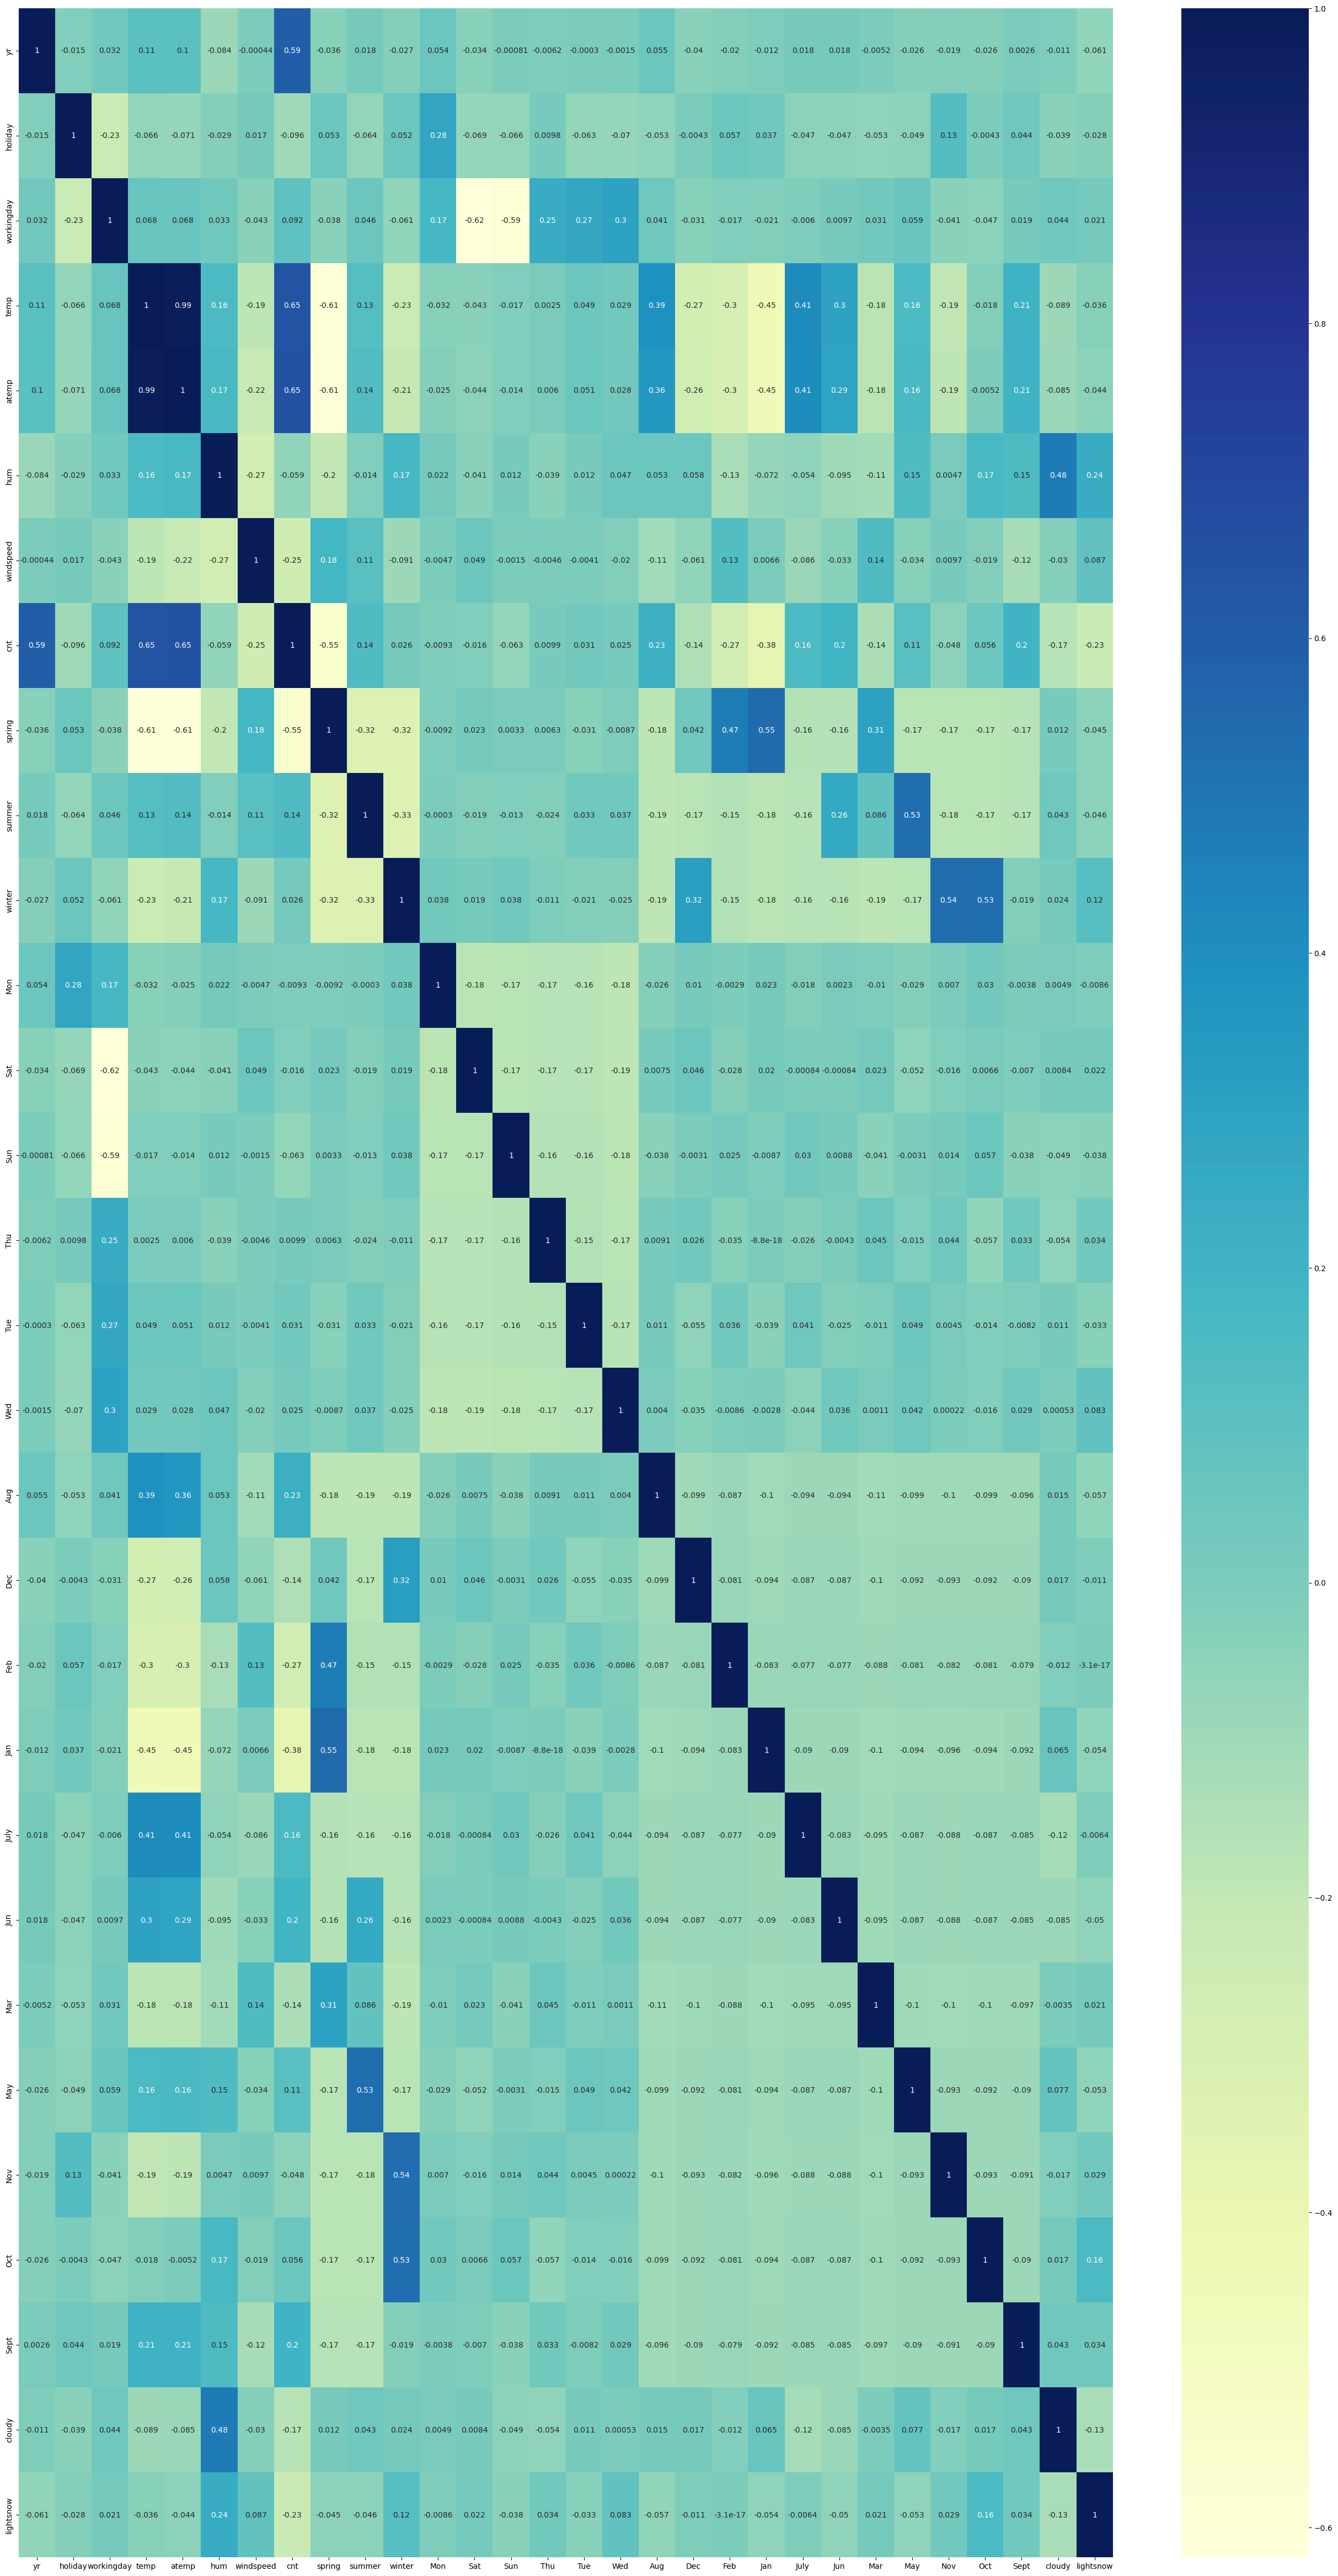

In [198]:
plt.figure(figsize = (32, 40))
sns.heatmap(df_train.corr(), annot = True, cmap = 'YlGnBu')
plt.show()

In [199]:
#Our predictor variable is count
Y_train = df_train.pop("cnt")
X_train = df_train

In [200]:
X_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,spring,summer,winter,...,Jan,July,Jun,Mar,May,Nov,Oct,Sept,cloudy,lightsnow
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0,0,0,...,0,1,0,0,0,0,0,0,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,1,0,0,...,0,0,0,1,0,0,0,0,1,0
728,1,0,0,0.245101,0.200348,0.498067,0.663106,1,0,0,...,0,0,0,0,0,0,0,0,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0,1,0,...,0,0,0,0,0,0,0,0,1,0
111,0,0,1,0.345824,0.318819,0.751824,0.380981,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [201]:
Y_train.head()

576    7216
426    4066
728    1796
482    4220
111    1683
Name: cnt, dtype: int64

In [202]:
# We will use Linear Regression using scikit learn so we can utilize RFE(Recursive Feature Elimination) to drop unwanted feature
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [203]:
lm = LinearRegression()
lm.fit(X_train, Y_train)
#Let's start with 20 columns out of 29
rfe = RFE(lm, n_features_to_select = 20)
rfe = rfe.fit(X_train, Y_train)

In [204]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('spring', True, 1),
 ('summer', False, 3),
 ('winter', False, 8),
 ('Mon', False, 7),
 ('Sat', True, 1),
 ('Sun', True, 1),
 ('Thu', False, 6),
 ('Tue', False, 5),
 ('Wed', False, 4),
 ('Aug', False, 9),
 ('Dec', True, 1),
 ('Feb', False, 2),
 ('Jan', True, 1),
 ('July', True, 1),
 ('Jun', False, 10),
 ('Mar', True, 1),
 ('May', True, 1),
 ('Nov', True, 1),
 ('Oct', True, 1),
 ('Sept', True, 1),
 ('cloudy', True, 1),
 ('lightsnow', True, 1)]

In [205]:
col = X_train.columns[rfe.support_]
col
#Let's build our model with all vaiables

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'spring', 'Sat', 'Sun', 'Dec', 'Jan', 'July', 'Mar', 'May', 'Nov',
       'Oct', 'Sept', 'cloudy', 'lightsnow'],
      dtype='object')

In [206]:
X_train.columns[~rfe.support_]

Index(['summer', 'winter', 'Mon', 'Thu', 'Tue', 'Wed', 'Aug', 'Feb', 'Jun'], dtype='object')

##### Now that we have removed some columns based on RFE selection we will use statsapi to build our model and observe its performance

In [207]:

X_train_rfe = X_train[col]
X_train_rfe = sm.add_constant(X_train_rfe)

#create model
lr = sm.OLS(Y_train, X_train_rfe)

#fit
lr_model = lr.fit()

#params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     143.0
Date:                Tue, 09 Apr 2024   Prob (F-statistic):          6.60e-186
Time:                        16:05:02   Log-Likelihood:                -4107.9
No. Observations:                 510   AIC:                             8256.
Df Residuals:                     490   BIC:                             8340.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2404.8960    224.406     10.717      0.000    1963.979    2845.813
yr          2033.1101     70.029     29.032      0.000    1895.515    2170.705
holiday       40.9366    186.959      0.219      0.827    -326.403     408.276
workingday   880.8703     81.354     10.828      0.000     721.024    1040.717
temp        2958.8800   1112.706      2.659      0.008     772.616    5145.144
atemp        722.9165   1168.783      0.619      0.537   -1573.528    3019.360
hum        -1310.4886    332.723     -3.939      0.000   -1964.229    -656.748
windspeed  -1596.6901    225.400     -7.084      0.000   -2039.559   -1153.821
spring     -1019.5988    130.836     -7.793      0.000   -1276.667    -762.531
Sat          980.5259     99.683      9.836      0.000     784.667    1176.385
Sun          502.5633    103.536      4.854      0.000     299.133     705.993
Dec          101.7444    155.714      0.653      0.514    -204.205     407.694
Jan         -298.4035    171.509     -1.740      0.083    -635.387      38.580
July        -524.7553    151.493     -3.464      0.001    -822.411    -227.100
Mar          211.4096    137.960      1.532      0.126     -59.657     482.476
May          306.2329    138.507      2.211      0.027      34.093     578.373
Nov          245.3463    156.074      1.572      0.117     -61.310     552.003
Oct          680.8319    146.320      4.653      0.000     393.340     968.324
Sept         689.3878    141.094      4.886      0.000     412.164     966.612
cloudy      -515.9441     90.956     -5.672      0.000    -694.656    -337.233
lightsnow  -2240.6673    230.711     -9.712      0.000   -2693.972   -1787.363
==============================================================================
Omnibus:                       84.304   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              231.263
Skew:                          -0.807   Prob(JB):                     6.05e-51
Kurtosis:                       5.877   Cond. No.                     2.52e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.54e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

##### We can see that R squared has not dropped our model holds good

#### Let''s observe the VIF values and compare with P values

In [208]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_train_rfe = X_train_rfe.drop("const", axis = 1)
vif = pd.DataFrame()
X = X_train_rfe
vif["Features"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["VIF"] = round(vif["VIF"], 3)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,temp,53.219
4,atemp,51.934
2,workingday,43.266
8,Sat,10.531
9,Sun,10.072
1,holiday,2.685
7,spring,2.660
11,Jan,1.998
5,hum,1.984
15,Nov,1.621


##### We can see that R squared has not dropped our model holds good
##### Temp has high VIF of 53.2 but low p of 0.008
##### atemp has high VIF of 53.2 but high p of 0.5
##### We will first drop atemp and observe variance again

In [209]:
X_train_rfe = X_train_rfe.drop(["atemp"], axis = 1)
X_train_rfe.head()

,yr,holiday,workingday,temp,hum,windspeed,spring,Sat,Sun,Dec,Jan,July,Mar,May,Nov,Oct,Sept,cloudy,lightsnow
576,1,0,1,0.815169,0.725633,0.264686,0,0,0,0,0,1,0,0,0,0,0,0,0
426,1,0,0,0.442393,0.640189,0.255342,1,1,0,0,0,0,1,0,0,0,0,1,0
728,1,0,0,0.245101,0.498067,0.663106,1,0,1,1,0,0,0,0,0,0,0,0,0
482,1,0,0,0.395666,0.504508,0.188475,0,1,0,0,0,0,0,0,0,0,0,1,0
111,0,0,1,0.345824,0.751824,0.380981,0,0,0,0,0,0,0,0,0,0,0,1,0


#### Observing VIF again

In [210]:

vif = pd.DataFrame()
X = X_train_rfe
vif["Features"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["VIF"] = round(vif["VIF"], 3)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,workingday,43.037
7,Sat,10.478
8,Sun,10.021
3,temp,3.418
1,holiday,2.682
6,spring,2.659
10,Jan,1.996
4,hum,1.978
14,Nov,1.617
9,Dec,1.578


#### Workingday has high VIF 43 but low P 0
#### From the data dictionary workingday is defined as if day is neither weekend nor holiday, workingday is 1, otherwise is 0. Now this information can be derived from columns holiday, Sat, Sun. If the day is neither holiday nor Sat nor Sun we can say working day will be 1.  So we will go ahead and drop this col

In [211]:
X_train_rfe = X_train_rfe.drop(["workingday"], axis = 1)
X_train_rfe.head()

,yr,holiday,temp,hum,windspeed,spring,Sat,Sun,Dec,Jan,July,Mar,May,Nov,Oct,Sept,cloudy,lightsnow
576,1,0,0.815169,0.725633,0.264686,0,0,0,0,0,1,0,0,0,0,0,0,0
426,1,0,0.442393,0.640189,0.255342,1,1,0,0,0,0,1,0,0,0,0,1,0
728,1,0,0.245101,0.498067,0.663106,1,0,1,1,0,0,0,0,0,0,0,0,0
482,1,0,0.395666,0.504508,0.188475,0,1,0,0,0,0,0,0,0,0,0,1,0
111,0,0,0.345824,0.751824,0.380981,0,0,0,0,0,0,0,0,0,0,0,1,0


In [212]:

vif = pd.DataFrame()
X = X_train_rfe
vif["Features"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["VIF"] = round(vif["VIF"], 3)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,hum,26.173
2,temp,16.679
4,windspeed,4.155
5,spring,3.082
16,cloudy,2.286
9,Jan,2.070
0,yr,2.064
13,Nov,1.575
8,Dec,1.574
11,Mar,1.531


#### Next humidity has high VIF of 26.1 and low P of 0, we will not remove it

#### Let's train the model again after dropping atemp column and observe its performance

In [213]:
X_train_rfe = sm.add_constant(X_train_rfe)
lr = sm.OLS(Y_train, X_train_rfe)

#fit
lr_model = lr.fit()

#params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     151.1
Date:                Tue, 09 Apr 2024   Prob (F-statistic):          6.40e-187
Time:                        16:05:25   Log-Likelihood:                -4108.1
No. Observations:                 510   AIC:                             8254.
Df Residuals:                     491   BIC:                             8335.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3298.1675    274.332     12.023      0.000    2759.158    3837.177
yr          2033.1248     69.985     29.051      0.000    1895.617    2170.632
holiday     -845.0683    223.730     -3.777      0.000   -1284.654    -405.483
temp        3624.6425    281.823     12.861      0.000    3070.915    4178.370
hum        -1298.8046    331.978     -3.912      0.000   -1951.077    -646.532
windspeed  -1620.8177    221.859     -7.306      0.000   -2056.728   -1184.908
spring     -1020.7990    130.739     -7.808      0.000   -1277.676    -763.922
Sat           99.6895     97.436      1.023      0.307     -91.754     291.133
Sun         -377.9280    101.086     -3.739      0.000    -576.543    -179.313
Dec          105.5813    155.492      0.679      0.497    -199.931     411.094
Jan         -301.4204    171.332     -1.759      0.079    -638.054      35.214
July        -523.3208    151.380     -3.457      0.001    -820.753    -225.889
Mar          215.3031    137.730      1.563      0.119     -55.310     485.916
May          311.5691    138.151      2.255      0.025      40.130     583.008
Nov          250.3789    155.763      1.607      0.109     -55.666     556.424
Oct          689.0639    145.622      4.732      0.000     402.945     975.183
Sept         690.8142    140.986      4.900      0.000     413.803     967.825
cloudy      -517.7980     90.849     -5.700      0.000    -696.299    -339.297
lightsnow  -2252.3353    229.794     -9.802      0.000   -2703.835   -1800.835
==============================================================================
Omnibus:                       83.699   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              230.368
Skew:                          -0.801   Prob(JB):                     9.47e-51
Kurtosis:                       5.877   Cond. No.                         18.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### We see that the columns Dec, Sat, Mar and Nov still have high P values, we will drop them one by one

#### We can also see that R squared has not dropped our model holds good

In [214]:
X_train_rfe = X_train_rfe.drop(["Dec", "const"], axis = 1)
X_train_rfe.head()

,yr,holiday,temp,hum,windspeed,spring,Sat,Sun,Jan,July,Mar,May,Nov,Oct,Sept,cloudy,lightsnow
576,1,0,0.815169,0.725633,0.264686,0,0,0,0,1,0,0,0,0,0,0,0
426,1,0,0.442393,0.640189,0.255342,1,1,0,0,0,1,0,0,0,0,1,0
728,1,0,0.245101,0.498067,0.663106,1,0,1,0,0,0,0,0,0,0,0,0
482,1,0,0.395666,0.504508,0.188475,0,1,0,0,0,0,0,0,0,0,1,0
111,0,0,0.345824,0.751824,0.380981,0,0,0,0,0,0,0,0,0,0,1,0


In [215]:
X_train_rfe = sm.add_constant(X_train_rfe)
lr = sm.OLS(Y_train, X_train_rfe)

#fit
lr_model = lr.fit()

#params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     160.1
Date:                Tue, 09 Apr 2024   Prob (F-statistic):          6.26e-188
Time:                        16:05:45   Log-Likelihood:                -4108.3
No. Observations:                 510   AIC:                             8253.
Df Residuals:                     492   BIC:                             8329.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3353.0104    262.029     12.796      0.000    2838.177    3867.844
yr          2034.2476     69.927     29.091      0.000    1896.855    2171.641
holiday     -843.3204    223.592     -3.772      0.000   -1282.634    -404.007
temp        3530.6822    245.377     14.389      0.000    3048.567    4012.797
hum        -1252.5874    324.747     -3.857      0.000   -1890.650    -614.525
windspeed  -1634.8489    220.773     -7.405      0.000   -2068.624   -1201.074
spring     -1034.7808    129.037     -8.019      0.000   -1288.311    -781.250
Sat          102.3409     97.305      1.052      0.293     -88.843     293.525
Sun         -379.5548    101.002     -3.758      0.000    -578.004    -181.106
Jan         -343.7687    159.490     -2.155      0.032    -657.134     -30.404
July        -521.4377    151.271     -3.447      0.001    -818.655    -224.220
Mar          188.2357    131.763      1.429      0.154     -70.652     447.123
May          291.9297    135.015      2.162      0.031      26.653     557.207
Nov          209.1468    143.361      1.459      0.145     -72.528     490.822
Oct          657.6328    137.993      4.766      0.000     386.504     928.761
Sept         674.1362    138.754      4.858      0.000     401.512     946.760
cloudy      -525.2448     90.135     -5.827      0.000    -702.343    -348.147
lightsnow  -2265.1544    228.891     -9.896      0.000   -2714.879   -1815.429
==============================================================================
Omnibus:                       83.815   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              230.629
Skew:                          -0.802   Prob(JB):                     8.31e-51
Kurtosis:                       5.878   Cond. No.                         18.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Our model R squared is very close to previous values.
#### col Sat still has high P value let's remove this next

In [216]:
X_train_rfe = X_train_rfe.drop(["Sat","const"], axis = 1)
X_train_rfe.head()

,yr,holiday,temp,hum,windspeed,spring,Sun,Jan,July,Mar,May,Nov,Oct,Sept,cloudy,lightsnow
576,1,0,0.815169,0.725633,0.264686,0,0,0,1,0,0,0,0,0,0,0
426,1,0,0.442393,0.640189,0.255342,1,0,0,0,1,0,0,0,0,1,0
728,1,0,0.245101,0.498067,0.663106,1,1,0,0,0,0,0,0,0,0,0
482,1,0,0.395666,0.504508,0.188475,0,0,0,0,0,0,0,0,0,1,0
111,0,0,0.345824,0.751824,0.380981,0,0,0,0,0,0,0,0,0,1,0


In [217]:
# Check model accuracy
X_train_rfe = sm.add_constant(X_train_rfe)
lr = sm.OLS(Y_train, X_train_rfe)

#fit
lr_model = lr.fit()

#params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     170.0
Date:                Tue, 09 Apr 2024   Prob (F-statistic):          8.18e-189
Time:                        16:05:50   Log-Likelihood:                -4108.9
No. Observations:                 510   AIC:                             8252.
Df Residuals:                     493   BIC:                             8324.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3381.9609    260.607     12.977      0.000    2869.923    3893.999
yr          2031.6992     69.893     29.069      0.000    1894.375    2169.024
holiday     -862.9988    222.832     -3.873      0.000   -1300.817    -425.181
temp        3522.2905    245.273     14.361      0.000    3040.381    4004.200
hum        -1261.9553    324.660     -3.887      0.000   -1899.843    -624.068
windspeed  -1627.0282    220.672     -7.373      0.000   -2060.602   -1193.455
spring     -1037.1272    129.031     -8.038      0.000   -1290.646    -783.608
Sun         -398.6444     99.369     -4.012      0.000    -593.883    -203.406
Jan         -343.0523    159.506     -2.151      0.032    -656.447     -29.658
July        -519.1559    151.272     -3.432      0.001    -816.374    -221.938
Mar          187.8786    131.777      1.426      0.155     -71.034     446.792
May          285.6190    134.896      2.117      0.035      20.577     550.661
Nov          206.5361    143.355      1.441      0.150     -75.126     488.198
Oct          659.0060    138.002      4.775      0.000     387.862     930.150
Sept         674.3002    138.769      4.859      0.000     401.648     946.952
cloudy      -523.9634     90.137     -5.813      0.000    -701.063    -346.864
lightsnow  -2262.4782    228.902     -9.884      0.000   -2712.221   -1812.735
==============================================================================
Omnibus:                       79.369   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              225.527
Skew:                          -0.749   Prob(JB):                     1.07e-49
Kurtosis:                       5.892   Cond. No.                         18.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Mar and Nov have higher P values, we will drop Mar next

In [218]:
X_train_rfe = X_train_rfe.drop(["Mar","const"], axis = 1)
X_train_rfe.head()

,yr,holiday,temp,hum,windspeed,spring,Sun,Jan,July,May,Nov,Oct,Sept,cloudy,lightsnow
576,1,0,0.815169,0.725633,0.264686,0,0,0,1,0,0,0,0,0,0
426,1,0,0.442393,0.640189,0.255342,1,0,0,0,0,0,0,0,1,0
728,1,0,0.245101,0.498067,0.663106,1,1,0,0,0,0,0,0,0,0
482,1,0,0.395666,0.504508,0.188475,0,0,0,0,0,0,0,0,1,0
111,0,0,0.345824,0.751824,0.380981,0,0,0,0,0,0,0,0,1,0


In [219]:
X_train_rfe = sm.add_constant(X_train_rfe)
lr = sm.OLS(Y_train, X_train_rfe)

#fit
lr_model = lr.fit()

#params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     180.8
Date:                Tue, 09 Apr 2024   Prob (F-statistic):          1.64e-189
Time:                        16:05:57   Log-Likelihood:                -4109.9
No. Observations:                 510   AIC:                             8252.
Df Residuals:                     494   BIC:                             8320.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3413.5271    259.936     13.132      0.000    2902.810    3924.244
yr          2032.4514     69.964     29.050      0.000    1894.988    2169.915
holiday     -883.2741    222.610     -3.968      0.000   -1320.654    -445.895
temp        3503.6549    245.181     14.290      0.000    3021.930    3985.380
hum        -1269.9372    324.951     -3.908      0.000   -1908.393    -631.481
windspeed  -1615.9704    220.766     -7.320      0.000   -2049.726   -1182.214
spring      -985.6766    124.011     -7.948      0.000   -1229.332    -742.022
Sun         -405.3051     99.363     -4.079      0.000    -600.531    -210.079
Jan         -420.6062    150.100     -2.802      0.005    -715.520    -125.692
July        -532.6070    151.135     -3.524      0.000    -829.554    -235.660
May          267.8842    134.462      1.992      0.047       3.697     532.072
Nov          185.0575    142.710      1.297      0.195     -95.336     465.451
Oct          638.7824    137.414      4.649      0.000     368.794     908.771
Sept         658.2500    138.456      4.754      0.000     386.214     930.286
cloudy      -521.1099     90.209     -5.777      0.000    -698.350    -343.870
lightsnow  -2251.5331    229.012     -9.832      0.000   -2701.491   -1801.575
==============================================================================
Omnibus:                       76.944   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              229.376
Skew:                          -0.711   Prob(JB):                     1.55e-50
Kurtosis:                       5.962   Cond. No.                         18.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Last value to remove is Nov, we will drop that

In [220]:
X_train_rfe = X_train_rfe.drop(["Nov", "const"], axis = 1)
X_train_rfe.head()

,yr,holiday,temp,hum,windspeed,spring,Sun,Jan,July,May,Oct,Sept,cloudy,lightsnow
576,1,0,0.815169,0.725633,0.264686,0,0,0,1,0,0,0,0,0
426,1,0,0.442393,0.640189,0.255342,1,0,0,0,0,0,0,1,0
728,1,0,0.245101,0.498067,0.663106,1,1,0,0,0,0,0,0,0
482,1,0,0.395666,0.504508,0.188475,0,0,0,0,0,0,0,1,0
111,0,0,0.345824,0.751824,0.380981,0,0,0,0,0,0,0,1,0


In [221]:
X_train_rfe = sm.add_constant(X_train_rfe)
lr = sm.OLS(Y_train, X_train_rfe)

#fit
lr_model = lr.fit()

#params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     193.4
Date:                Tue, 09 Apr 2024   Prob (F-statistic):          2.67e-190
Time:                        16:06:04   Log-Likelihood:                -4110.8
No. Observations:                 510   AIC:                             8252.
Df Residuals:                     495   BIC:                             8315.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3494.2283    252.550     13.836      0.000    2998.026    3990.431
yr          2034.0701     70.001     29.058      0.000    1896.535    2171.606
holiday     -843.0164    220.586     -3.822      0.000   -1276.418    -409.615
temp        3386.8168    228.182     14.843      0.000    2938.493    3835.141
hum        -1234.4485    324.019     -3.810      0.000   -1871.071    -597.826
windspeed  -1614.5826    220.915     -7.309      0.000   -2048.630   -1180.535
spring     -1047.8134    114.458     -9.155      0.000   -1272.698    -822.929
Sun         -402.7175     99.411     -4.051      0.000    -598.037    -207.398
Jan         -435.8721    149.741     -2.911      0.004    -730.078    -141.666
July        -535.0825    151.227     -3.538      0.000    -832.209    -237.956
May          240.1782    132.845      1.808      0.071     -20.831     501.187
Oct          594.1747    133.130      4.463      0.000     332.604     855.745
Sept         633.2563    137.203      4.615      0.000     363.685     902.827
cloudy      -529.3145     90.049     -5.878      0.000    -706.239    -352.390
lightsnow  -2255.2372    229.152     -9.842      0.000   -2705.467   -1805.007
==============================================================================
Omnibus:                       75.407   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              220.696
Skew:                          -0.702   Prob(JB):                     1.19e-48
Kurtosis:                       5.900   Cond. No.                         18.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Value of R Aquared is holding which is good. May has higher P Value, we will drop it next

In [222]:
X_train_rfe.head()
X_train_rfe = X_train_rfe.drop(["May", "const"], axis = 1)

In [224]:
X_train_rfe = sm.add_constant(X_train_rfe)
lr = sm.OLS(Y_train, X_train_rfe)

#fit
lr_model = lr.fit()

#params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     207.0
Date:                Tue, 09 Apr 2024   Prob (F-statistic):          9.20e-191
Time:                        16:09:31   Log-Likelihood:                -4112.5
No. Observations:                 510   AIC:                             8253.
Df Residuals:                     496   BIC:                             8312.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3455.5627    252.218     13.701      0.000    2960.016    3951.110
yr          2028.4800     70.092     28.940      0.000    1890.766    2166.194
holiday     -855.7699    220.977     -3.873      0.000   -1289.937    -421.603
temp        3440.2933    226.773     15.171      0.000    2994.739    3885.848
hum        -1162.4741    322.299     -3.607      0.000   -1795.713    -529.235
windspeed  -1603.1949    221.330     -7.243      0.000   -2038.055   -1168.335
spring     -1070.5873    114.023     -9.389      0.000   -1294.615    -846.559
Sun         -402.3145     99.638     -4.038      0.000    -598.079    -206.550
Jan         -430.4496    150.053     -2.869      0.004    -725.267    -135.632
July        -586.7514    148.842     -3.942      0.000    -879.189    -294.313
Oct          554.7001    131.628      4.214      0.000     296.083     813.317
Sept         584.5620    134.840      4.335      0.000     319.633     849.491
cloudy      -529.8330     90.254     -5.870      0.000    -707.160    -352.506
lightsnow  -2281.0249    229.230     -9.951      0.000   -2731.406   -1830.644
==============================================================================
Omnibus:                       72.488   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              201.036
Skew:                          -0.692   Prob(JB):                     2.22e-44
Kurtosis:                       5.746   Cond. No.                         18.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### We see that the R squared is holding and all P values are holding, we will check VIF again

In [225]:
X_train_rfe = X_train_rfe.drop("const", axis = 1)
vif = pd.DataFrame()
X = X_train_rfe
vif["Features"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["VIF"] = round(vif["VIF"], 3)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,hum,16.459
2,temp,12.430
4,windspeed,3.976
5,spring,2.394
11,cloudy,2.145
0,yr,2.040
7,Jan,1.649
8,July,1.418
9,Oct,1.226
12,lightsnow,1.224


#### Humidity and Temperature still have high VIF values and low P(0). We will drop hum next and observe VIF

In [227]:
X_train_rfe = X_train_rfe.drop("hum", axis = 1)
vif = pd.DataFrame()
X = X_train_rfe
vif["Features"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["VIF"] = round(vif["VIF"], 3)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,temp,4.750
3,windspeed,3.857
4,spring,2.153
0,yr,2.038
6,Jan,1.602
10,cloudy,1.512
7,July,1.352
9,Sept,1.222
8,Oct,1.173
5,Sun,1.169


#### All our VIF values are now below 5, let's fit the model again

In [228]:
X_train_rfe = sm.add_constant(X_train_rfe)
lr = sm.OLS(Y_train, X_train_rfe)

#fit
lr_model = lr.fit()

#params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     217.9
Date:                Tue, 09 Apr 2024   Prob (F-statistic):          3.65e-189
Time:                        16:14:30   Log-Likelihood:                -4119.1
No. Observations:                 510   AIC:                             8264.
Df Residuals:                     497   BIC:                             8319.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2765.6556    166.371     16.623      0.000    2438.778    3092.534
yr          2054.4942     70.558     29.118      0.000    1915.866    2193.122
holiday     -871.5045    223.588     -3.898      0.000   -1310.798    -432.211
temp        3296.6465    225.930     14.591      0.000    2852.751    3740.542
windspeed  -1368.0927    214.054     -6.391      0.000   -1788.655    -947.530
spring     -1053.8093    115.296     -9.140      0.000   -1280.338    -827.281
Sun         -427.8081    100.580     -4.253      0.000    -625.423    -230.193
Jan         -446.6869    151.787     -2.943      0.003    -744.910    -148.464
July        -533.8562    149.896     -3.562      0.000    -828.365    -239.348
Oct          496.6336    132.209      3.756      0.000     236.877     756.390
Sept         553.8025    136.187      4.067      0.000     286.230     821.375
cloudy      -714.1491     75.287     -9.486      0.000    -862.068    -566.230
lightsnow  -2599.7775    214.050    -12.146      0.000   -3020.331   -2179.224
==============================================================================
Omnibus:                       74.440   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              209.960
Skew:                          -0.705   Prob(JB):                     2.56e-46
Kurtosis:                       5.809   Cond. No.                         11.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

###  Our R Squared is at 84 and VIF and P values are both low. Adjusted R value is also good 83.6%
### Prob(F-Statistic) is a low value indicating significance of model is good
### AIC and BIC increased but by a very little amount so we are good

## Residual Analysis of the training data

#### We want to confirm that the error terms are normally distributed which is one of assumptions of linear regression

In [229]:
y_train_pred = lr_model.predict(X_train_rfe)
y_train_pred

576    6611.501842
426    4161.272660
728    3239.353017
482    5152.520975
111    2670.349023
          ...     
578    7412.337133
53     2227.430837
350    2279.023947
79     2851.819088
520    5592.765372
Length: 510, dtype: float64

C:\Users\chetna.priyadarshin\AppData\Local\Temp\ipykernel_9584\3046913830.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(res)


<Axes: ylabel='Density'>

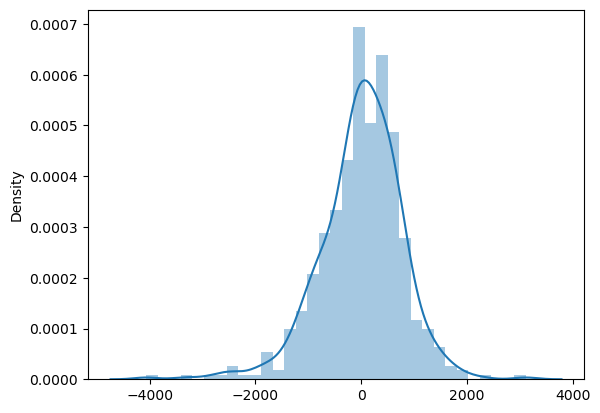

In [230]:
#compute the residual
res = Y_train - y_train_pred
sns.distplot(res)

In [302]:
res

576     604.498158
426     -95.272660
728   -1443.353017
482    -932.520975
111    -987.349023
          ...     
578    -151.337133
53     -310.430837
350     459.976053
79     -774.819088
520    1408.234628
Length: 510, dtype: float64

##### Plot a scatter plot to confirm that there are no patterns emerging in residual

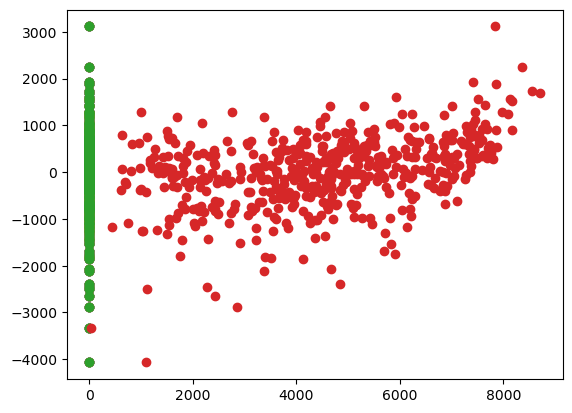

In [300]:
res_df = pd.DataFrame(res)

for col in X_train_rfe:
    plt.scatter(X_train_rfe[col], res_df )
    plt.show

##### It is interesting to note that the values are centered around 0, with no obvious pattern, however the variance seems to increase at higher values. They are no in cone shape proving homoscedasticity

#### Let's confirm that linear relationship exists between cnt and other columns of training data set

In [301]:
Y_data = pd.DataFrame(Y_train)

C:\Users\chetna.priyadarshin\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


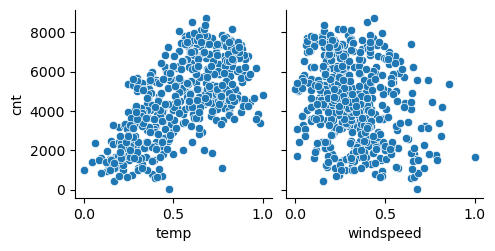

In [295]:
data = X_train_rfe
data["cnt"] = Y_data["cnt"]
sns.pairplot(data= data, 
                  x_vars=['temp', 'windspeed'],
                  y_vars=['cnt'])

#### We can see that there is linear relationship between count and temp but windspeed data is more spread out

### Making prediction on test set and evaluating the model on the test set

In [232]:
num_vars = ['temp', 'atemp', 'hum', 'windspeed']
df_test[num_vars] = scaler.transform(df_test[num_vars])
df_test.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,Jan,July,Jun,Mar,May,Nov,Oct,Sept,cloudy,lightsnow
184,0,1,0,0.831783,0.769660,0.657364,0.084219,6043,0,0,...,0,1,0,0,0,0,0,0,1,0
535,1,0,1,0.901354,0.842587,0.610133,0.153728,6211,0,1,...,0,0,1,0,0,0,0,0,0,0
299,0,0,1,0.511964,0.496145,0.837699,0.334206,2659,0,0,...,0,0,0,0,0,0,1,0,1,0
221,0,0,1,0.881625,0.795343,0.437098,0.339570,4780,0,0,...,0,0,0,0,0,0,0,0,0,0
152,0,0,1,0.817246,0.741471,0.314298,0.537414,4968,0,1,...,0,0,1,0,0,0,0,0,0,0


In [234]:
df_test.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,Jan,July,Jun,Mar,May,Nov,Oct,Sept,cloudy,lightsnow
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,...,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.481818,0.036364,0.700000,0.558718,0.532847,0.638221,0.313293,4560.559091,0.254545,0.263636,...,0.077273,0.104545,0.095455,0.054545,0.086364,0.072727,0.086364,0.086364,0.318182,0.027273
std,0.500809,0.187620,0.459303,0.233187,0.217401,0.148694,0.159584,1904.968544,0.436599,0.441609,...,0.267633,0.306665,0.294512,0.227609,0.281541,0.260281,0.281541,0.281541,0.466833,0.163248
min,0.000000,0.000000,0.000000,0.046591,0.025950,0.261915,-0.042808,441.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.355429,0.344870,0.529197,0.198843,3312.750000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.558172,0.544652,0.625590,0.300126,4582.500000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.755981,0.713308,0.743798,0.402718,5913.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,0.984424,0.980934,1.002146,0.807474,8395.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [235]:
y_test = df_test.pop("cnt")
x_test = df_test

In [236]:
x_test_sm = sm.add_constant(x_test)
x_test_sm.head()

,const,yr,holiday,workingday,temp,atemp,hum,windspeed,spring,summer,...,Jan,July,Jun,Mar,May,Nov,Oct,Sept,cloudy,lightsnow
184,1.0,0,1,0,0.831783,0.769660,0.657364,0.084219,0,0,...,0,1,0,0,0,0,0,0,1,0
535,1.0,1,0,1,0.901354,0.842587,0.610133,0.153728,0,1,...,0,0,1,0,0,0,0,0,0,0
299,1.0,0,0,1,0.511964,0.496145,0.837699,0.334206,0,0,...,0,0,0,0,0,0,1,0,1,0
221,1.0,0,0,1,0.881625,0.795343,0.437098,0.339570,0,0,...,0,0,0,0,0,0,0,0,0,0
152,1.0,0,0,1,0.817246,0.741471,0.314298,0.537414,0,1,...,0,0,1,0,0,0,0,0,0,0


#### Drop the variavles that were from training col.

In [243]:
x_test_sm = x_test_sm.drop(["atemp", "hum", "May", "Nov", "Mar", "Sat", "Dec", "workingday",
                            'summer', 'winter', 'Mon', 'Thu', 'Tue', 'Wed', 'Aug', 'Feb', 'Jun'], axis = 1)

In [244]:
x_test_sm.head()

,const,yr,holiday,temp,windspeed,spring,Sun,Jan,July,Oct,Sept,cloudy,lightsnow
184,1.0,0,1,0.831783,0.084219,0,0,0,1,0,0,1,0
535,1.0,1,0,0.901354,0.153728,0,0,0,0,0,0,0,0
299,1.0,0,0,0.511964,0.334206,0,0,0,0,1,0,1,0
221,1.0,0,0,0.881625,0.339570,0,0,0,0,0,0,0,0
152,1.0,0,0,0.817246,0.537414,0,0,0,0,0,0,0,0


#### Make prediction

In [245]:
y_test_pred = lr_model.predict(x_test_sm)

#### Evaulate the model

In [246]:
from sklearn.metrics import r2_score
r2_score(y_true = y_test, y_pred = y_test_pred)

0.8150651390582366

### Training Set had R2 square of 84% and Test set has R2 square of 81.5%
### We can safely say that model has learnt well and generalized well on the test set

cnt = 2054.49 * yr - 871.50 * holiday + 3296.65 * temp - 1368.01 * windspeed - 1053.81 * spring - 427.81 * Sun - 446.69 * Jan
-533.86 * July + 496.63 * Oct + 553.80 * Sept - 714.15 * cloudy - 2599.78 * lightsnow